In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Read Data

In [2]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

## Amazon Fashion

In [3]:
data_path = 'Data/Amazon/'
# file_name = 'Amazon_full' # file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'am_80k_users'
file_name = 'am_40k_users'

## MovieLens

In [4]:
data_path = 'data/ML/'
file_name = 'ml_1m'
# file_name = 'ML_full' # file_name = 'ML_05_users'
# file_name = 'ML_01_users'

In [33]:
test_set_cfrnn = pd.read_pickle(path + data_path + 'test_set_ml_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + 'val_set_ml_cfrnn')
train_set_cfrnn = pd.read_pickle(path + data_path + 'train_set_ml_cfrnn')

In [111]:
test_set = pd.read_pickle(path + data_path + 'ml_1m_test')
train_set = pd.read_pickle(path + data_path + 'ml_1m_train')

In [39]:
from Data_prep import leave_last_x_out_2

add_to_train, val_set = leave_last_x_out_2(val_set_cfrnn)
add_to_train_2, test_set = leave_last_x_out_2(test_set_cfrnn)

train_set = pd.concat([train_set_cfrnn, add_to_train, add_to_train_2])

In [112]:
df = pd.read_pickle(path + data_path + file_name)
df.user_id = df.user_id.astype('category').cat.codes
df.item_id = df.item_id.astype('category').cat.codes
df.head()

,rating,datetime,user_id,item_id
0,4,2000-12-31 22:00:19,0,2969
1,4,2000-12-31 22:00:55,0,1574
2,5,2000-12-31 22:00:55,0,957
3,5,2000-12-31 22:00:55,0,1178
4,3,2000-12-31 22:01:43,0,2147


## Create Subset

In [367]:
from Data_prep import leave_users_out
remaining, subset = leave_users_out(df, 40000)
df = subset
df.user_id = df.user_id.astype('category').cat.codes
df.item_id = df.item_id.astype('category').cat.codes

---
# Data Prep

## Dataset Params

In [8]:
val_perc = test_perc = 0.1
n_last_items_val = n_last_items_test = 1

total_items = len(df.item_id.unique())
total_users = len(df.user_id.unique())

## Create Split

In [246]:
test_set = pd.DataFrame()
train_set = pd.DataFrame()
pbar = progressbar.ProgressBar()
for u in pbar(df.user_id.unique()):
    last_item = df[df.user_id==u].iloc[-1:]
    test_set = test_set.append(last_item)
    remaining = df[df.user_id==u].iloc[:-1]
    train_set = pd.concat([train_set, remaining])

100% |########################################################################|


In [7]:
from Data_prep import train_val_test_split
datasets = train_val_test_split(df, val_perc, test_perc, n_last_items_val, n_last_items_test)
train_set, val_set, test_set = datasets

In [8]:
file_name

'am_40k_users'

---
# Bayesian Personalized Ranking
- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

## Parameters

In [82]:
params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 20, #around 20 is sufficient
"sample_size": 0.5*len(train_set),
"seed": 1234,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.45, # Bold driver decrease alpha
          
#Regularizers, still tweaking the values
# Amazon_01 best: 0.1
# ML_1 best: 0
"reg_user": 0.001, #0.1,
"reg_item": 0.001, #0.1,
}

In [83]:
from BPR import BPR
bpr = BPR(total_users, total_items, params)
file_name

'ml_1m'

## Create Samples

In [60]:
samples = bpr.create_samples(train_set)

Creating 20 samples of length 499354


100% |########################################################################|


#### Store Samples

In [61]:
# samples_name = '/ml_1m_samples'
samples_name = '/ml_1m_samples_cfrnn'

In [62]:
samples = np.array(samples)
np.save(path + data_path + samples_name, samples)

## Fit

In [84]:
%%time
bpr.train_model(sample_path=path + data_path + samples_name + '.npy', val_set=val_set)

iteration: 0  loss: 0.582837  rec@10: 0.02
iteration: 1  loss: 0.312791  rec@10: 0.028
iteration: 2  loss: 0.262332  rec@10: 0.028
iteration: 3  loss: 0.238829  rec@10: 0.028
iteration: 4  loss: 0.233736  rec@10: 0.024
iteration: 5  loss: 0.24142  rec@10: 0.024
iteration: 6  loss: 0.234307  rec@10: 0.022
iteration: 7  loss: 0.219226  rec@10: 0.026
iteration: 8  loss: 0.212886  rec@10: 0.028
iteration: 9  loss: 0.210233  rec@10: 0.014
iteration: 10  loss: 0.209289  rec@10: 0.022
iteration: 11  loss: 0.208847  rec@10: 0.028
iteration: 12  loss: 0.211388  rec@10: 0.022
iteration: 13  loss: 0.205349  rec@10: 0.026
iteration: 14  loss: 0.198377  rec@10: 0.028
iteration: 15  loss: 0.195319  rec@10: 0.024
iteration: 16  loss: 0.193441  rec@10: 0.026
iteration: 17  loss: 0.191502  rec@10: 0.016
iteration: 18  loss: 0.191437  rec@10: 0.026
iteration: 19  loss: 0.192441  rec@10: 0.028
CPU times: user 7min 28s, sys: 3.83 s, total: 7min 32s
Wall time: 7min 48s


## Store Model

In [106]:
log_path = path + 'Results/BPR/'
res_name = 'BPR_models_ml_1m'
# model.store_results(log_path, res_name, file_name)

In [107]:
df_res = pd.read_pickle(log_path + res_name)

In [108]:
df_res

,train_loss,val_auc,train_speed,lr,file,nolf,n_iterations,sample_size,seed,alpha,reg_user,reg_item,p,q,rho,sigma
0,"[0.4280874360060686, 0.23456262467076563, 0.21...",[],971.526762,"[0.08, 0.07968, 0.07936128, 0.03968064, 0.0198...",ml_1m,8,20,999001,1234,0.08,0,0,"[[0.1511637915719814, -0.3173339449339406, -0....","[[2.49902713106001, -1.6457139347826235, -4.27...",NaN,NaN
1,"[0.4273768647927152, 0.23884409152682956, 0.21...",[],968.177193,"[0.08, 0.07968, 0.07936128, 0.03968064, 0.0395...",ml_1m,8,20,994169,1234,0.08,0,0,"[[-0.14674822722927147, 0.3385207321191396, -0...","[[1.313975950703949, 2.2223455161709165, 2.508...",NaN,NaN
2,"[0.4262480005459771, 0.23891997015179622, 0.21...",[],837.310544,"[0.08, 0.07968, 0.07936128, 0.03968064, 0.0395...",ml_1m,8,20,994169,1234,0.08,0,0,"[[0.7062134945576238, -0.4566284163975517, -0....","[[3.220768283452017, 0.2016917509859173, -0.35...",NaN,NaN
3,"[0.4508524392013311, 0.24924464826477136, 0.20...",[],228.437804,"[0.08, 0.07936, 0.07872512, 0.07809531904, 0.0...",ml_1m,8,10,497084,1234,0.08,0,0,"[[0.033347353356346345, 0.10166072154450412, -...","[[3.1402685295419395, 1.508107767833505, -0.80...",NaN,NaN
4,"[0.4508524392013311, 0.24924464826477136, 0.19...",[],496.584120,"[0.08, 0.07968, 0.07936128, 0.0790438348800000...",ml_1m,8,20,497084,1234,0.08,0,0,"[[0.2411571377163555, 0.3360608490615798, -0.5...","[[3.3246752727347806, 1.5053034277758417, -0.8...",NaN,NaN
5,"[0.4508524392013311, 0.24924464826477136, 0.19...",[],547.059173,"[0.08, 0.084, 0.08820000000000001, 0.092610000...",ml_1m,8,20,497084,1234,0.08,0,0,"[[0.24527480565794993, 0.01755084268110578, -0...","[[3.1529183545320145, 1.5572832363552516, -1.0...",1.05,0.4
6,"[0.582082236535849, 0.3014259883347379, 0.2475...",[],309.974249,"[0.08, 0.084, 0.08820000000000001, 0.092610000...",ml_1m,8,10,497084,1234,0.08,0,0,"[[0.9023469273880115, 0.8155246383309424, -0.2...","[[3.5050459007548582, 4.271195964389365, 0.948...",1.05,0.4
7,"[0.6766144152127932, 0.4058353176703962, 0.297...",[],584.064584,"[0.08, 0.08800000000000001, 0.0968000000000000...",ml_1m,8,20,298251,1234,0.08,0,0,"[[0.9575058629503107, 0.453533453886671, -0.05...","[[4.29282246430047, 3.127852818720075, -1.2866...",1.10,0.5


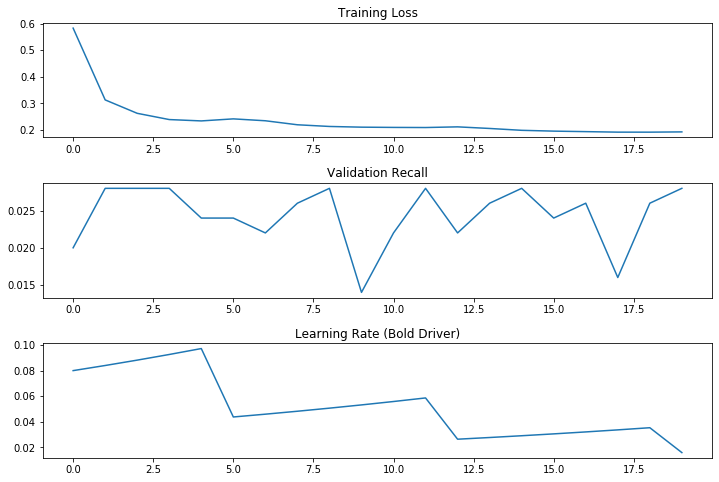

In [100]:
bpr.plot_training()

In [109]:
model.model['p'] = df_res.iloc[7]['p']
model.model['q'] = df_res.iloc[7]['q']

# Evaluation

In [55]:
rank_at = 20
steps = 5

## Ranking and Metrics

In [113]:
ranked_df = model.get_predictions(test_set)

Ranking time: 1.56


In [114]:
from Evaluation import get_metrics
metrics = get_metrics(ranked_df, steps, rank_at)
metrics

Obtaining metrics time: 7.55


,rank_at,hitcounts,recall,precision,ndcg
0,1,14,0.002318,0.002318,0.002318
1,5,70,0.011589,0.002318,0.006913
2,10,130,0.021523,0.002152,0.010097
3,15,210,0.034768,0.002318,0.013594
4,20,283,0.046854,0.002343,0.016442


## ML for CFRNN

In [128]:
ranked_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039],
           dtype='int64', name='user_id', length=6040)

In [129]:
from Evaluation import get_metrics
metrics = get_metrics(ranked_df, steps, rank_at)
metrics

Obtaining metrics time: 6.4


,rank_at,hitcounts,recall,precision,ndcg
0,1,14,0.002318,0.002318,0.002318
1,5,70,0.011589,0.002318,0.006913
2,10,130,0.021523,0.002152,0.010097
3,15,210,0.034768,0.002318,0.013594
4,20,283,0.046854,0.002343,0.016442


In [103]:
metrics.to_pickle(path + 'Results/BPR/metrics_ml_1m_cfrnn')

In [383]:
metrics.to_pickle(path + 'Results/BPR/metrics_all_sample_am_40k')

## Sample Predictions

In [27]:
%%time
from Evaluation import get_metrics
sample_sizes = [20, 50, 100, 500, 1000, 5000]
metrics = []
for sample_size in sample_sizes:
        ranked_sample_df = BPR_ml_1m.sample_prediction(train_set, test_set, sample_size)
        metric = get_metrics(ranked_sample_df)
        metrics.append(metric)
        metric.to_pickle(path + f'Results/BPR/metrics_ml_1m_nolf_8_{sample_size}')        

100% |########################################################################|


Obtaining metrics time: 6.51


100% |########################################################################|


Obtaining metrics time: 6.61


100% |########################################################################|


Obtaining metrics time: 6.73


100% |########################################################################|


Obtaining metrics time: 7.08


100% |########################################################################|


Obtaining metrics time: 7.0


100% |########################################################################|


Obtaining metrics time: 7.05
CPU times: user 2min 6s, sys: 2.61 s, total: 2min 8s
Wall time: 2min 3s


In [115]:
ranked_sample_df = model.sample_prediction(train_set, test_set)

100% |########################################################################|


In [ ]:
metrics_sample = get_metrics(ranked_sample_df, steps, rank_at)

In [21]:
metrics_sample

,rank_at,hitcounts,recall,precision,ndcg
0,1,481,0.12025,0.120250,0.120250
1,5,756,0.18900,0.037800,0.154836
2,10,951,0.23775,0.023775,0.170575
3,15,1142,0.28550,0.019033,0.183205
4,20,1303,0.32575,0.016287,0.192657


In [118]:
metrics_sample.to_pickle(path + 'Results/BPR/metrics_ml_1m_100_sample')

In [122]:
metrics_sample

,rank_at,hitcounts,recall,precision,ndcg
0,1,835,0.138245,0.138245,0.138245
1,5,2450,0.405629,0.081126,0.275441
2,10,3500,0.579470,0.057947,0.331504
3,15,4154,0.687748,0.045850,0.360125
4,20,4580,0.758278,0.037914,0.376779


## This one with new bold driver approach

In [144]:
metrics_sample

,rank_at,hitcounts,recall,precision,ndcg
0,1,880,0.145695,0.145695,0.145695
1,5,2509,0.415397,0.083079,0.283357
2,10,3545,0.586921,0.058692,0.338873
3,15,4236,0.701325,0.046755,0.369178
4,20,4688,0.776159,0.038808,0.386845


In [66]:
metrics_sample.to_pickle(path + 'Results/BPR/metrics_100_sample_ml_1m')

## Visualise Results

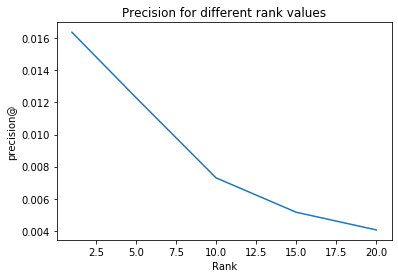

In [57]:
plt.plot(metrics['rank_at'], metrics['precision'])
plt.xlabel('Rank')
plt.ylabel('precision@')
plt.title('Precision for different rank values')
plt.show()

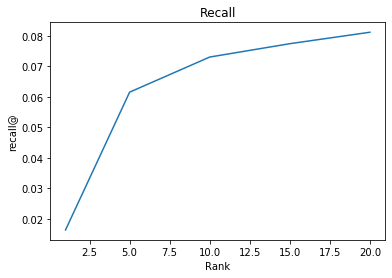

In [58]:
plt.plot(metrics['rank_at'], metrics['recall'])
plt.xlabel('Rank')
plt.ylabel('recall@')
plt.title('Recall')
plt.show()

---
# Grid Search
- Amazon_01_users
- ML_01_users

In [55]:
def read_get_train_test(file_path, file_name):
    # Init 
    df = pd.read_pickle(file_path + file_name)
    df['item_id'] = df.item.astype('category').cat.codes
    df['user_id'] = df.user.astype('category').cat.codes

    # Create Train and Test sets
    BATCH_SIZE = 64
    val_perc = test_perc = 0.1
    n_last_items_val = n_last_items_test = 1
    return train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test, stats=False) 

In [68]:
def full_run(total_users, total_items, train_set, val_set, test_set, params, sample_perc, n_full_runs=1):
    print('Run:', str(1) ,'/', str(n_full_runs))
    # Model Run
    params['sample_size'] = sample_perc*len(train_set)
    model = BPR(total_users, total_items, params)
    model.fit(train_set,verbose=0)
    
    # Evaluation
    rank_at = 20
    steps = 5
    ranked_df = rank_predictions(model.model, test_set, rank_at, stats=False)
    full_metrics = get_metrics(ranked_df, steps, rank_at, stats=False)
    
    for i in range(n_full_runs-1):
        print('Run:', str(i+2) ,'/', str(n_full_runs))
        model = BPR(total_users, total_items, params)
        model.fit(train_set, verbose=0)

        # Evaluation
        ranked_df = rank_predictions(model.model, test_set, rank_at, stats=False)
        full_metrics += get_metrics(ranked_df, steps, rank_at, stats=False)
    
    full_metrics /= n_full_runs
    return model, full_metrics

## Amazon

In [69]:
params = {
"nolf":20, # Size of latent feature vectors
"n_iterations":40, # Depends on number of items and users
"sample_size":1, # Adjusted in loop to sample_perc*len(train_set)
"seed":0, # 0 Means no seed and samples will be drawn differently every time
"alpha":0.1, # Learning rate
          
#Regularizers
"reg_user":0.03, # should be in proportion to the number of items 
"reg_item":0.03,
}

In [70]:
path

'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'

## Init

In [73]:
file_names = ['Amazon_01_users']
file_paths = [path + 'Data/Amazon/']
ext = 'Am'
store_path = path + 'Results/BPR/Grid_Search/learning_rate/'

n_iterations = [40]
regs = [0.1]
nolfs = [20]
sample_percs = [0.4]
alphas = [0.001, 0.01, 0.05, 0.08, 0.1, 0.12, 0.15]

runs = 0
all_runs = len(n_iterations) * len(regs) * len(nolfs) * len(sample_percs) * len(alphas)

## Run Grid Search

In [74]:
from Evaluation import rank_predictions, get_metrics
from Data_prep import train_val_test_split
for file_name, file_path in zip(file_names, file_paths):
    #Get data split and variables needed for BPR
    total_users, total_items, train_set, val_set, test_set = read_get_train_test(file_path, file_name)
    for n_iters in n_iterations:
        params['n_iterations'] = n_iters
        for reg in regs:
            params['reg_user'] = reg
            params['reg_item'] = reg
            for nolf in nolfs:
                params['nolf'] = nolf
                for alpha in alphas:
                    params['alpha'] = alpha
                    for sample_perc in sample_percs:
                        # Track Progress
                        runs += 1
                        print('\n', '='*60, '\n', 'Run:', runs, '/', all_runs)
                        print('File:\t\t\t', file_name)
                        print('Iterations:\t\t', n_iters)
                        print('Regularisation:\t\t', reg)
                        print('NOLF:\t\t\t', nolf)
                        print('Learning Rate:\t\t', alpha)
                        print('Sample Percentage:\t', sample_perc)

                        # Result name
                        final_name = ext + '_' + str(n_iters) + '_' + str(nolf) + '_' + str(reg) + '_' + str(alpha) + '_' + str(sample_perc)

                        # Run
                        model, metrics = full_run(total_users, total_items, train_set, val_set, test_set, params, sample_perc, 10)

                        # Store TODO: Should be in full run
                        res_name = 'BPR_models'
                        model.store_results(store_path, res_name, final_name, stats=False)
                        metrics.to_pickle(store_path + 'metrics_' + final_name)


 Run: 1 / 7
File:			 Amazon_01_users
Iterations:		 40
Regularisation:		 0.1
NOLF:			 20
Learning Rate:		 0.001
Sample Percentage:	 0.4
Run: 1 / 10
Run: 2 / 10
Run: 3 / 10
Run: 4 / 10
Run: 5 / 10
Run: 6 / 10
Run: 7 / 10
Run: 8 / 10
Run: 9 / 10
Run: 10 / 10

 Run: 2 / 7
File:			 Amazon_01_users
Iterations:		 40
Regularisation:		 0.1
NOLF:			 20
Learning Rate:		 0.01
Sample Percentage:	 0.4
Run: 1 / 10
Run: 2 / 10
Run: 3 / 10
Run: 4 / 10
Run: 5 / 10
Run: 6 / 10
Run: 7 / 10
Run: 8 / 10
Run: 9 / 10
Run: 10 / 10

 Run: 3 / 7
File:			 Amazon_01_users
Iterations:		 40
Regularisation:		 0.1
NOLF:			 20
Learning Rate:		 0.05
Sample Percentage:	 0.4
Run: 1 / 10
Run: 2 / 10
Run: 3 / 10
Run: 4 / 10
Run: 5 / 10
Run: 6 / 10
Run: 7 / 10
Run: 8 / 10
Run: 9 / 10
Run: 10 / 10

 Run: 4 / 7
File:			 Amazon_01_users
Iterations:		 40
Regularisation:		 0.1
NOLF:			 20
Learning Rate:		 0.08
Sample Percentage:	 0.4
Run: 1 / 10
Run: 2 / 10
Run: 3 / 10
Run: 4 / 10
Run: 5 / 10
Run: 6 / 10
Run: 7 / 10
Run: 8 / 10


# Appendix

In [ ]:
# df = pd.read_pickle('Data/amazon_clothing_shoes_jewelry_data')
# users = df.user.unique()
# to_keep = users[:300000]

# user_indices = df.groupby('user')['index'].apply(list)
# to_keep_indices = []
# for u in user_indices[to_keep]:
#     to_keep_indices.extend(u)

# new_df = df_og.loc[to_keep_indices]
# len(to_keep_indices)

## standard SVD model

In [ ]:
# class SVD:
#     """" All functions used to run, test, plot and store the
#     Singular Value Decomposition Model"""

#     def __init__(self, params, total_users, total_items):
#         self.nolf = params['nolf']
#         self.n_epochs = params['n_epochs']
#         self.alpha = params['alpha']
#         self.alpha_b = params['alpha_b']
#         self.alpha_cb = params['alpha_cb']
#         self.use_bias = params['use_bias']
#         self.use_impl_fb = params['use_impl_fb']
#         self.use_color = params['use_color']
#         self.use_weight_ver = params['use_weight_ver']
#         self.bu_reg = params['bu_reg']
#         self.bi_reg = params['bi_reg']
#         self.pu_reg = params['pu_reg']
#         self.qi_reg = params['qi_reg']
#         self.x_reg = params['x_reg']
#         self.cb_reg = params['cb_reg']
#         self.ver_weight = params['ver_weight']
#         self.stop = params['stop']
#         self.random_state = params['random_state']
#         self.total_users = total_users
#         self.total_items = total_items
#         self.params = params
#         self.mu = 0 
#         self.N = []
#         self.N_test = []
#         self.t = pd.DataFrame()
#         self.c = pd.DataFrame()
#         self.F = pd.DataFrame()

#         self.train_data = pd.DataFrame()
#         self.test_data = pd.DataFrame()
#         self.val_data = pd.DataFrame()
#         self.train_time = 0
#         self.best_model = {}
#         self.model = {}
#         self.test_results = {}

#     def fit(self, train_data, val_data=[], verbose=1, plot=True, plot_name=''):
#         self.train_data = train_data
#         self.val_data = val_data
#         self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot, plot_name=plot_name)
#         return self

    
# ###############################################################################################
    
#     def SVD(self, train_data, val_data, verbose, plot, plot_name):
#         """"The SVD algorithm with sgd
#         input: rating dataset with columns:['rating', 'user_id', 'item_id']
#         output: the resulting p, q, bi, bu matrices"""
#         self.mu = self.create_mu(train_data)
#         train_matrix = self.create_matrix(train_data, self.total_users, self.total_items)
        
#         tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
#         p = np.random.normal(0, .1, (total_users, self.nolf))  # users
#         q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
#         # user and item biases
#         b_user = np.zeros(total_users)
#         b_item = np.zeros(total_items)
        
#         # using color (pareto split (0,1,2)) attribute bias
#         if self.use_color:
#             print('Creating F and c, for incorporating color bias')
#             self.F, self.c = self.init_color(train_data)

#         # implicit fb rated, not rated
#         x = np.random.normal(0, .1, (total_items, self.nolf))
#         impl_fb_u = np.zeros(self.nolf)
#         if self.use_impl_fb:
#             print('Creating N, for incorporating implicit feedback')
#             self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
#         # 0.5 weight on the errors of verified = False user item combinations
#         if self.use_weight_ver:
#             i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
#             i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
#         sqrt_Nu = 0
#         cb = 0
#         rmses = []
#         val_rmses = []
#         smallest_val_rmse = 10000
#         val_rmse = "na"
#         start = time.time()
#         for epoch in range(self.n_epochs):
#             total_sq_error = 0
#             for u, i, r_ui in tuples_train:
#                 u = int(u)
#                 i = int(i)
                
#                 if self.use_impl_fb:
#                     impl_fb_u = np.zeros(self.nolf)
#                     sqrt_Nu = np.sqrt(len(self.N[u]))
#                     for j in self.N[u]:
#                         impl_fb_u += x[j] / sqrt_Nu

#                 if self.use_color and epoch > 5:
#                     F_ui =  self.F[u,i] #Set of items associated with i and rated by u
#                     u_mu = self.mu + b_user[u]
#                     sqrt_F_ui = np.sqrt(len(F_ui))
#                     for index, f in enumerate(F_ui):
#                         r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
#                         cb += (r_uf - u_mu) * self.c[u,i][index]
#                     cb /=  sqrt_F_ui
                        
#                 if self.use_bias:   
#                     error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
#                     if self.use_weight_ver and not i_verified[u,i]:
#                         error = self.ver_weight * error
                    
#                     b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
#                     b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
#                 else:
#                     error = r_ui - np.dot(p[u], q[i])

#                 p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
#                 q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
#                 total_sq_error += np.square(error)
            
#                 if self.use_impl_fb:
#                     for j in self.N[u]:
#                         x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
#                 if self.use_color and epoch > 5:
#                     for index, f in enumerate(F_ui):
#                         r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
#                         u_mu = self.mu + b_user[u]
#                         self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
#             rmse = np.sqrt(total_sq_error / len(tuples_train))
#             rmses.append(rmse)
            
#             self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
#             # Validation
#             if len(val_data) > 0:
#                 new_val_rmse = self.test(val_data, val=True)
#                 val_rmses.append(new_val_rmse)
#                 if new_val_rmse < smallest_val_rmse:
#                     smallest_val_rmse = new_val_rmse
#                     self.best_model = copy.deepcopy(self.model)
#                 val_rmse = new_val_rmse
                
#             # Epoch Printing
#             if epoch % verbose == 0:
#                 if len(val_data) > 0:
#                     print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
#                 else:
#                     print('Epoch:', epoch, '  RMSE:', rmse)
            
#             if self.stop and val_rmses[-2:][0] < val_rmse:
#                 print('BREAK: Validation set not improving anymore')
#                 break
                
#         if plot:
#             self.plot_rmse(rmses, val_rmses, plot_name)

#         self.train_time = time.time() - start
#         self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
# #################################################################################################

#     def init_color(self, data_set):
#         self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
#         F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
#         c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
#         return F, c

#     def sim_items(self, x, random=False):
#         u_id = x.name[0]
#         col = x.iloc[0]
#         if random:
#             return np.random.normal(0,.1,len(self.t[u_id, col]))
#         return self.t[u_id, col]
    
#     def create_matrix(self, X_train, n_users, n_items):
#         r = X_train['new_user_id']
#         c = X_train['new_item_id']
#         d = X_train['rating']
#         train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
#         return train_matrix.tocsr()
    
#     def create_mu(self, train_set):
#         # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
#         va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
#         vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
#         k = va/vb #variance proportion
#         better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
#         return better_mu
    
#     def plot_rmse(self, rmse, val_rmses=[], plot_name=''):
#         plt.plot(np.arange(len(rmse)), rmse)
#         if len(val_rmses) > 0:
#             plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
#         plt.title('RMSE')
#         plt.xlabel('epoch')
#         plt.ylabel('RMSE')
#         plt.legend(['Train', 'Validation'])
#         if len(plot_name) > 0:
#             plt.savefig('Plots/' + plot_name + '.png')
#         plt.show()

#     def test(self, test_data, val=False):
#         if not val:
#             self.test_data = test_data
#         tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
#         test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
#         if self.use_impl_fb and val:
#             self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
#         elif self.use_impl_fb:
#             self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
#         total_error = 0
#         estimates = []
#         for u, i, r_ui in tuples_test:
#             u = int(u)
#             i = int(i)
#             est = self.estimate(u, i, test_matrix, test_data)
#             estimates.append(est)
#             total_error += np.square(r_ui - est)
        
#         rmse = np.sqrt(total_error / len(tuples_test))
        
#         if not val:
#             self.test_results = {'rmse': rmse, 'estimates':estimates}
#             print('RMSE on test set:', self.test_results['rmse'])
#         else:
#             return rmse

#     def estimate(self, u, i, test_matrix, test_data):
#         est = self.mu + self.model['bu'][u] + self.model['bi'][i]
#         impl_fb_u = np.zeros(self.nolf)
#         cb = 0
#         if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
#             if self.use_impl_fb and u in self.N.index:
#                 sqrt_Nu = np.sqrt(len(self.N[u]))
#                 for j in self.N[u]:   
#                     impl_fb_u += self.model['x'][j] / sqrt_Nu
            
#             if self.use_color and (u,i) in self.model['cbu']:
#                 F_ui =  self.F[u,i] #Set of items associated with i and rated by u
#                 u_mu = self.mu + self.model['bu'][u]
#                 sqrt_F_ui = np.sqrt(len(F_ui))
#                 for index, f in enumerate(F_ui):
#                     r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
#                     cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
#                 cb /=  sqrt_F_ui
                
#             est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

#         return est
    
#     def store_results(self, log_path, res_name, user_thres, item_thres):
#         train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
#         test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
#         val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
#         result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
#         other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse'], 'val_rmse':self.model['val_rmse']}
#         final_log = dict(result_info, **self.params, **other_info)

#         if not os.path.exists(log_path + res_name):
#             df_results = pd.DataFrame(columns=final_log.keys())
#             print('new results created')

#         else:
#             df_results = pd.read_pickle(log_path + res_name)
#             print('results added')

#         df_results = df_results.append(final_log, ignore_index=True)
#         pd.to_pickle(df_results, log_path + res_name)

In [ ]:
# class BPR():
#     def __init__(self, total_users, total_items, params):
#         self.total_users = total_users
#         self.total_items = total_items
#         self.nolf = params['nolf']
#         self.n_iterations = params['n_iterations']
#         self.alpha = params['alpha']
#         self.reg_user = params['reg_user']
#         self.reg_item = params['reg_item']
#         self.reg_bias = params['reg_bias']
#         self.alpha_decay = self.alpha / self.n_iterations
#         self.model = {'loss_list':[], 'learning_rate':[]}
        
#     def fit(self, train_set, val_set, val_rank, batch_size=1000):
#         #Init
#         s = time.time()
#         self.model['p'] = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
#         self.model['q'] = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
#         self.model['b'] = np.zeros(self.total_items)
        
# #         val_prec_at = []
# #         val_rec_at = []
# #         val_hitcount = []
        
#         # Create samples 
#         n_sgd_samples = len(train_set) * self.n_iterations
        
#         z = 0
#         self.model['train_time'] = 0
#         print('init and sampling done:', time.time() - s, 'seconds')
#         for i in range(self.n_iterations):
#             sgd_users, sgd_pos_items, sgd_neg_items = self.user_sampling(train_set, n_sgd_samples)
        
#         while (z+1)*batch_size < n_sgd_samples:
#             s_it = time.time()
#             it_loss = self.train(sgd_users[z*batch_size:(z+1)*batch_size], sgd_pos_items[z*batch_size:(z+1)*batch_size], sgd_neg_items[z*batch_size:(z+1)*batch_size])
            
#             if z > 0:
#                 self.update_alpha(it_loss)
            
#             z += 1
#             self.model['loss_list'].append(it_loss) 

# #             rec_at, prec_at, hitcount = self.eval(val_set, val_rank)
#             t_it = time.time()- s_it
#             self.model['train_time'] += t_it
#             print('batch:', z, ' loss:', round(it_loss,4), 'iteration time:', round(t_it/2,2))#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
    
# #             val_prec_at.append(prec_at)
# #             val_rec_at.append(rec_at)
# #             val_hitcount.append(hitcount)
            
# #         self.model['val_prec_at'] = val_prec_at
# #         self.model['val_rec_at'] = val_rec_at
# #         self.model['val_hitcount'] = val_hitcount
        
        
#     def create_matrices(self, data):
#         r = data['new_user_id']
#         c = data['new_item_id']
#         d = data['rating']
#         m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
#         m_ones = m.copy()
#         m_ones[m_ones > 0] = 1                 
#         return m, m_ones
    
#     def sigmoid(self, x):
#         return 1 / (1 + math.exp(-x))
    
#     def user_sampling(self, data, n_samples):
#         train_ratings, train_ones = self.create_matrices(train_set)
#         user_items = train_set.groupby('new_user_id')['new_item_id'].apply(list)
#         train_users  = train_set.new_user_id.unique()
#         train_items = train_set.new_item_id.unique()
        
#         sgd_users, sgd_pos_items, sgd_neg_items = [], [], []
#         for sample in range(n_samples):
#             u = np.random.choice(train_users)
#             i = random.choice(user_items[u])

#             j = int(np.random.choice(train_items)) # neg item
# #             j_v = int(train_ones[u,j]) # Value, NEEDED?

#             while j in user_items[u]: # j cannot be the same item or an item with a 1
#                 j = int(np.random.choice(train_items))
# #                 j_v = int(train_ones[u,j])
            
#             sgd_users.append(u)
#             sgd_pos_items.append(i)
#             sgd_neg_items.append(j)
            
#         return sgd_users, sgd_pos_items, sgd_neg_items
        
#     def train(self, users, pos_items, neg_items):
#         for u, i, j in zip(users, pos_items, neg_items):
#             pos_item_pred = self.model['b'][i] + np.dot(self.model['p'][u], self.model['q'][i].T)
#             neg_item_pred = self.model['b'][j] + np.dot(self.model['p'][u], self.model['q'][j].T)
#             diff = pos_item_pred - neg_item_pred

#             loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
#             regulariser = self.reg_user * np.dot(self.model['p'][u], self.model['p'][u]) + self.reg_item * np.dot(self.model['q'][i],self.model['q'][i]) + self.reg_item/10 * np.dot(self.model['q'][j], self.model['q'][j]) + self.reg_bias * (self.model['b'][i]**2 + self.model['b'][j]**2) 
#             it_loss = loss_value + regulariser

#             diff_deriv = self.sigmoid(- diff)
            
#             #SGD update
#             for f in range(self.nolf): # update each factor (see notes for derivatives)
#                 self.model['p'][u,f] += self.alpha * (diff_deriv * (self.model['q'][i,f] - self.model['q'][j,f]) - self.reg_user * self.model['p'][u,f])
#                 self.model['q'][i,f] += self.alpha * (diff_deriv * self.model['p'][u,f] - self.reg_item * self.model['q'][i,f])
#                 self.model['q'][j,f] += self.alpha * (diff_deriv * (-self.model['p'][u,f]) - self.reg_item / 10 * self.model['q'][j,f])
#                 self.model['b'][i] += self.alpha * (diff_deriv * self.reg_bias * self.model['b'][i])
#                 self.model['b'][j] += self.alpha * (- diff_deriv * (- self.reg_bias) * self.model['b'][j])

# #                 it_loss += self.reg_user * self.model['p'][u,f] * self.model['p'][u,f] + self.reg_item * self.model['q'][i,f] * self.model['q'][i,f] + self.reg_item * self.model['q'][j,f] * self.model['q'][j,f]
#         return it_loss
        
#     def update_alpha(self, it_loss):
#         last_loss = self.model['loss_list'][-1]
#         if(last_loss < it_loss): #bold driver
#             self.alpha = 0.5 * self.alpha
#             return
        
#         self.alpha = (1 - self.alpha_decay) * self.alpha
#         self.model['learning_rate'].append(self.alpha)
        
#     def eval(self, val_set, max_rank):
#         import eval_rank
#         val_ratings, val_ones = create_matrices(val_set, self.total_users, self.total_items)
#         result = self.model
#         users = val_set.new_user_id.unique()
#         items = val_set.new_item_id.unique()

#         s = time.time()
#         rank_at = max_rank
#         mp_splits = 4
#         users_split = np.array_split(users, mp_splits)

#         if __name__ == '__main__':
#             pool = mp.Pool(processes = mp_splits)
#             ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, val_ones, rank_at], 
#                                                     [result, users_split[1], items, val_ones, rank_at], 
#                                                     [result, users_split[2], items, val_ones, rank_at], 
#                                                     [result, users_split[3], items, val_ones, rank_at]])
#             pool.close()

#             ranked_df = pd.DataFrame()

#             for i in range(mp_splits):
#                 ranked_df = pd.concat([ranked_df, ranked[i]])

#             t = time.time() - s
#             hitcount = 0
#             for u in ranked_df.index:
#                 hitcount += len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked']))

#             prec_at =  hitcount / (len(ranked_df) * rank_at)
#             rec_at = hitcount / (len(ranked_df) * len(ranked_df.loc[0]['true_id']))
            
#             return prec_at, rec_at, hitcount
# #             print(t)